# Revisited

## Importing and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

SEED = 321
np.random.seed(SEED)

In [2]:
filename = 'Data\sales_predictions_2023.csv'
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Cleaning

### Droping Columns

In [3]:
df = df.drop(columns=['Item_Identifier', 'Outlet_Identifier'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


### Duplicates

In [4]:
df.duplicated().sum()

0

### Missing Values

In [5]:
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
print(df.isna().sum().sum(), 'missing values')

3873 missing values


## Train/Split Data

In [7]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Column Selector and One Hot Encoding

In [8]:
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [9]:
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [10]:
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

C:\Users\aliss\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.026300,79.4302,1987.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2957,7.93,0.071136,42.7086,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,0.041313,42.0454,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Liner Regression

In [11]:
lin_reg = LinearRegression()
lin_fit = lin_reg.fit(X_train_df, y_train)

In [12]:
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           -2.018351
Item_Visibility                     -422.374939
Item_MRP                              15.715542
Outlet_Establishment_Year             28.448501
Item_Fat_Content_Low Fat              59.471724
Item_Fat_Content_Regular             123.854582
Item_Fat_Content_low fat             121.612043
Item_Fat_Content_reg                  16.735916
Item_Type_Breads                     -28.441001
Item_Type_Breakfast                   46.466658
Item_Type_Canned                      27.562504
Item_Type_Dairy                     -107.176197
Item_Type_Frozen Foods                -0.397310
Item_Type_Fruits and Vegetables       46.676728
Item_Type_Hard Drinks                 12.681833
Item_Type_Health and Hygiene          27.747380
Item_Type_Household                    6.504272
Item_Type_Meat                       -12.054212
Item_Type_Others                     -23.996997
Item_Type_Seafood                    327.692020
Item_Type_Snack Foods                -21

### Visualize 

In [13]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:

        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:

        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()

        title = f"Top {top_n} Largest Coefficients"
        
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')

    return ax

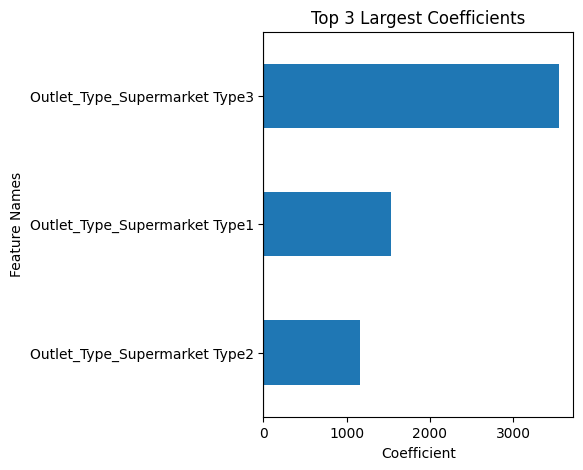

In [14]:
ax= plot_coeffs(coeffs,top_n=3)

## Tree-Based Model

In [15]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [16]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 431.35
Test Data:	R^2= 0.55	RMSE= 1115.75


In [17]:
reg.feature_importances_

array([0.05540248, 0.10137768, 0.44229604, 0.04236739, 0.00740066,
       0.00687624, 0.00171522, 0.00175061, 0.00279937, 0.00286224,
       0.00445617, 0.0067291 , 0.00583998, 0.00784133, 0.00303377,
       0.00382966, 0.00649201, 0.003765  , 0.00171634, 0.00181595,
       0.00866781, 0.00577115, 0.00317152, 0.00419183, 0.02603599,
       0.00680857, 0.00310086, 0.00334896, 0.09475678, 0.02233825,
       0.11144103])

In [18]:
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

31
31


True

In [19]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                        0.055402
Item_Visibility                    0.101378
Item_MRP                           0.442296
Outlet_Establishment_Year          0.042367
Item_Fat_Content_Low Fat           0.007401
Item_Fat_Content_Regular           0.006876
Item_Fat_Content_low fat           0.001715
Item_Fat_Content_reg               0.001751
Item_Type_Breads                   0.002799
Item_Type_Breakfast                0.002862
Item_Type_Canned                   0.004456
Item_Type_Dairy                    0.006729
Item_Type_Frozen Foods             0.005840
Item_Type_Fruits and Vegetables    0.007841
Item_Type_Hard Drinks              0.003034
Item_Type_Health and Hygiene       0.003830
Item_Type_Household                0.006492
Item_Type_Meat                     0.003765
Item_Type_Others                   0.001716
Item_Type_Seafood                  0.001816
Item_Type_Snack Foods              0.008668
Item_Type_Soft Drinks              0.005771
Item_Type_Starchy Foods         

In [20]:
importances.sum()

1.0

In [21]:
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Item_MRP                           0.442296
Outlet_Type_Supermarket Type3      0.111441
Item_Visibility                    0.101378
Outlet_Type_Supermarket Type1      0.094757
Item_Weight                        0.055402
Outlet_Establishment_Year          0.042367
Outlet_Size_Medium                 0.026036
Outlet_Type_Supermarket Type2      0.022338
Item_Type_Snack Foods              0.008668
Item_Type_Fruits and Vegetables    0.007841
Item_Fat_Content_Low Fat           0.007401
Item_Fat_Content_Regular           0.006876
Outlet_Size_Small                  0.006809
Item_Type_Dairy                    0.006729
Item_Type_Household                0.006492
Item_Type_Frozen Foods             0.005840
Item_Type_Soft Drinks              0.005771
Item_Type_Canned                   0.004456
Outlet_Size_MISSING                0.004192
Item_Type_Health and Hygiene       0.003830
Item_Type_Meat                     0.003765
Outlet_Location_Type_Tier 3        0.003349
Item_Type_Starchy Foods         

### Visualize 

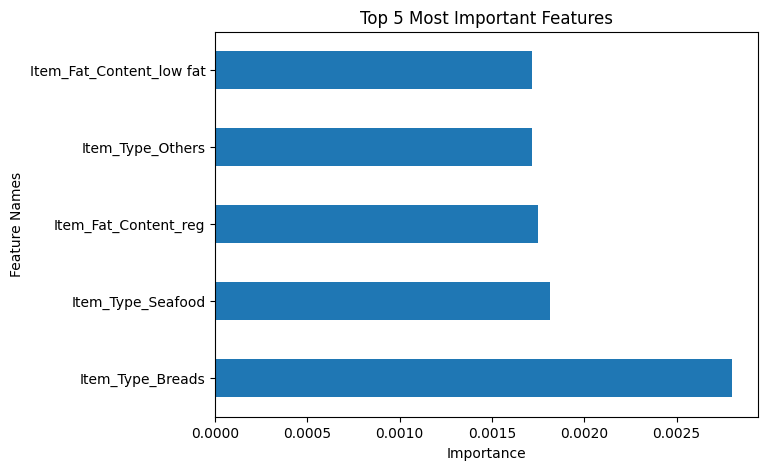

In [22]:
ax = sorted_importance.tail(5).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');

## Joblib

In [23]:
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':reg}
joblib.dump(export, 'random_forest_l01.joblib')

['random_forest_l01.joblib']

In [24]:
loaded = joblib.load('random_forest_l01.joblib')
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest'])

In [25]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    if feature_names == None:
        feature_names = model.feature_names_in_
    
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [26]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):

    if top_n==None:

        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:

        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"

    if color_dict is not None:

        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:

        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    return ax

In [27]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
loaded_model = loaded['RandomForest']

Training Data:	R^2= 0.94	RMSE= 431.35
Test Data:	R^2= 0.55	RMSE= 1115.75


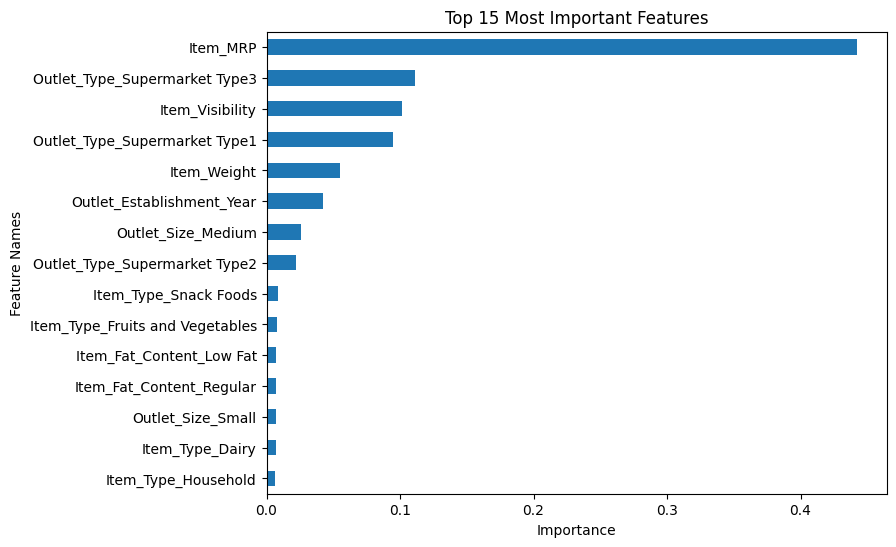

In [28]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)
loaded_importances = get_importances(loaded_model)
plot_importance_color(loaded_importances,top_n=15,color_dict=None);